In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as sp

In [2]:
df = pd.read_csv('FleetAll.csv')
df=df.drop(columns=['Vehicle Category','GVWR Class','MPO'])
df = df.where(df['Model Year'] != 'Unknown').dropna()

In [3]:
years = np.arange(2018,2036)
years_missing=[2018, 2019, 2020, 2021, 2022, 2026, 2027, 2028,
       2029, 2030, 2031, 2032, 2033, 2034, 2035]
sales_percentage_missing = [7.6,7.6,8.1,12.8,17.9,35,43,51,59,68,76,82,88,94,100]
f= sp.interp1d(years_missing,sales_percentage_missing)
sales_percentage = []
for i in years:
    sales_percentage.append(f(i))


In [4]:
times = df.drop(columns=['Fuel Type'])
times = times.where(times['Model Year'] != 'Unknown').dropna()
times['Model Year'] = times['Model Year'].astype(int)
times = times.groupby(['Model Year']).sum()

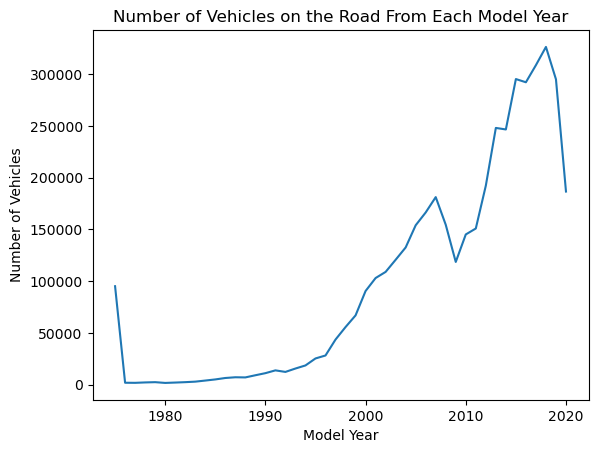

In [5]:
shortened = times.drop(2021, axis = 0)
plt.plot(shortened)
plt.ylabel('Number of Vehicles')
plt.xlabel('Model Year')
plt.title('Number of Vehicles on the Road From Each Model Year')
plt.show()

In [6]:
f2 = sp.CubicSpline([1980,1990,2002,2015,2018],np.log([1801,11219.0-1000,108976.0-30000,295129.0-1050,326147.0-1000])
                    , extrapolate=True)

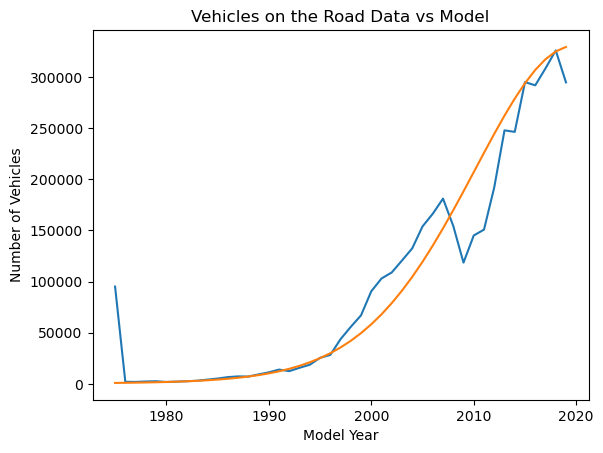

In [7]:
plt.figure()
plt.plot(np.arange(1975,2020),times['Vehicle Population'][np.arange(1975,2020)])
plt.plot(np.arange(1975,2020),np.exp(f2(np.arange(1975,2020))))
plt.ylabel('Number of Vehicles')
plt.xlabel('Model Year')
plt.title('Vehicles on the Road Data vs Model')
plt.show()

In [8]:
pops = np.array(times['Vehicle Population'])
coef = sum(pops)/sum(np.exp(f2(range(1960,2020))))
def model(year):
    return coef*np.exp(f2(year))

In [9]:
pops = np.array(times['Vehicle Population'])
weighted_avg_tot = 0
for i in range(47):
    weighted_avg_tot += pops[i]*(1975+i)

weighted_avg = weighted_avg_tot/sum(pops)
weighted_avg

2009.83158810058

In [10]:
weighted_model_tot = 0
for i in range(1960,2020):
    weighted_model_tot += model(i)*(i)

weighted_model = weighted_model_tot/sum(pops)
weighted_model

2010.7739982374567

In [11]:
evf = df.where(df['Fuel Type'] == 'Electric').dropna()
evf = evf.where(evf['Model Year'] != 'Unknown').dropna()
evf = evf.drop('Fuel Type', axis = 1)
evf = evf.groupby(['Model Year']).sum()

icef = df.where(df['Fuel Type'] == 'Gasoline').dropna()
icef = icef.where(icef['Model Year'] != 'Unknown').dropna()
icef = icef.drop('Fuel Type', axis = 1)
icef = icef.groupby(['Model Year']).sum()


icef = icef.rename(columns={"Vehicle Population": "ICE Population"})
evf = evf.rename(columns={"Vehicle Population": "EV Population"})
dfn = icef.merge(evf, how = 'outer',on='Model Year')
dfn = dfn.fillna(0)

In [12]:
total_years = np.array(range(1975,2036))
EV_percent = np.array(dfn["EV Population"]/(dfn["EV Population"]+dfn["ICE Population"]))
EV_percent = np.append(EV_percent,sales_percentage[4:])
percents = pd.DataFrame(data = {'total_years': total_years, 'EV_percent': EV_percent})

In [13]:
pred_pop = []
pred_EV = []
for i in range(1960,2020):
    pred_pop.append(model(i))
    pred_EV.append(model(i)*(percents.iloc[i-1960,1])/100)
sum(pred_EV)

2038394.7246369882

In [14]:
total_percent_ev = sum(pred_EV)/sum(pred_pop)
total_percent_ev

0.45659363881633613

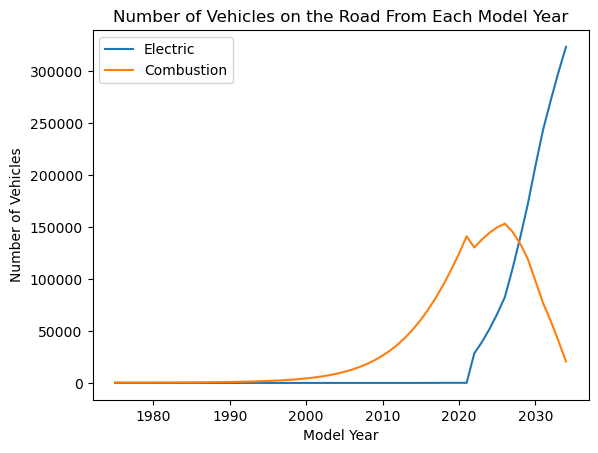

In [15]:
plt.figure()
plt.plot(np.arange(1975,2035),pred_EV)
#plt.plot(np.arange(1975,2035),pred_pop)
plt.plot(np.arange(1975,2035),np.subtract(pred_pop,pred_EV))
plt.ylabel('Number of Vehicles')
plt.xlabel('Model Year')
plt.title('Number of Vehicles on the Road From Each Model Year')
plt.legend(['Electric', 'Combustion'])
plt.show()

In [41]:
np.subtract(pred_pop,pred_EV)

array([   427.69261756,    413.23948065,    405.06054086,    402.59846299,
          405.54464771,    413.80814394,    427.52638846,    446.98303949,
          472.6903933 ,    505.36520263,    545.96139508,    595.70574678,
          656.14543785,    729.20916775,    817.28316057,    923.31105766,
         1050.9023778 ,   1204.48362693,   1389.46339281,   1612.47593075,
         1881.55568588,   2206.50949048,   2599.23766505,   3074.12300602,
         3648.51890788,   4343.30321236,   5183.40798354,   6198.47181867,
         7423.67712834,   8900.19454032,  10676.08142202,  12806.8331055 ,
        15355.85947947,  18394.65487351,  22003.31689926,  26268.66481567,
        31282.62564749,  37147.05003437,  43956.08396642,  51814.41227106,
        60808.01117265,  71009.21999263,  82468.29793766,  95170.13202316,
       109246.71509134, 124561.41184025, 141219.69245336, 130454.20978294,
       138105.59145411, 144677.6208556 , 149884.24956015, 153452.056084  ,
       145619.01494183, 1

In [16]:
## emfac ice VMT
ivmt = 135746176.5
iem = 14187691.56
emiss_per_mile = iem/ivmt
emiss_per_mile

0.10451632543771869

In [17]:
emiss_per_mile*91

9.5109856148324

In [18]:
evmt = 16422882.15
total_vmt = ivmt + evmt
total_vmt/10**6

152.16905865

In [19]:
evmt/total_vmt

0.10792523983324254

In [20]:
total_vmt*(1-total_percent_ev)*emiss_per_mile

8642416.744056959

In [21]:
evmt = total_vmt*(total_percent_ev)
evmt

69479424.20425998

In [28]:
hybrid = 1-1980921.815/(1980921.815+14441960.34)
hybrid

0.8793803793814046

In [29]:
#electricity
emfac_vmt = 11732296.39
emfac_energy = 4529634.726
emfac_energy_eff = emfac_energy/emfac_vmt
emfac_energy_eff

0.38608253452076313

In [30]:
evmt = total_vmt*(total_percent_ev)*hybrid
evmt*emfac_energy_eff

23589195.936232243

In [31]:
evmt = total_vmt*(total_percent_ev)
high = evmt
total_vmt - high*hybrid

91070216.23405632

In [32]:
evmt = total_vmt*(0.32322201126560557)
low = evmt*emfac_energy_eff
low*hybrid

16698759.47990242

In [33]:
evmt = total_vmt*(0.4217366135393132)
med = evmt
med*hybrid

56434467.54639788

In [34]:
152-56

96

In [35]:
(14441960+1980921)/14441960

1.1371642768710064

In [37]:
total_vmt/10**6

152.16905865

In [38]:
evmt = total_vmt*(total_percent_ev)
high = evmt*hybrid
ivmt = total_vmt-high
ivmt

91070216.23405632

In [39]:
evmt = total_vmt*(0.32322201126560557)
high = evmt*hybrid
ivmt = total_vmt-high
ivmt

108917271.82511741

In [35]:
evmt = total_vmt*(0.4217366135393132)
high = evmt*hybrid
ivmt = total_vmt-high
ivmt

95734591.10360213

In [34]:
evmt

64175263.480516136